In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os  
from matplotlib.ticker import PercentFormatter
from scipy.optimize import curve_fit


# plot cpu, gpu power pattern for GPGPU apps
def replace_negative_with_average(data, column_name):
    for i in range(1, len(data) - 1):
        if data.at[i, column_name] < 0:
            previous_value = data.at[i - 1, column_name]
            next_value = data.at[i + 1, column_name]
            data.at[i, column_name] = (previous_value + next_value) / 2

def plot_power_CPU_GPU(cpu_filename, gpu_filename, benchmark, x=4,y=3, y_val=450):
    # Load the CSV files into DataFrames
    cpu_data = pd.read_csv(cpu_filename)
    gpu_data = pd.read_csv(gpu_filename)

    # Replace negative values with the average of the previous and next values
    replace_negative_with_average(cpu_data, 'Package Power (W)')
    replace_negative_with_average(gpu_data, 'GPU 0 Power (W)')

    # Plot the data
    plt.figure(figsize=(x, y))
    plt.plot(cpu_data['Time (s)'], cpu_data['Package Power (W)'], label='RAPL Package Power')
    plt.plot(gpu_data['Time (s)'], gpu_data['GPU 0 Power (W)'], label='GPU Power')
    plt.xlabel('Time (s)')
    plt.ylabel('Power (W)')
    plt.title(f'Power Consumption ({benchmark})', pad=40)
    plt.ylim(0, y_val)
    # Position the legend outside the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
    plt.grid(True, axis="y", alpha=0.5)
    os.makedirs('./fig', exist_ok=True)
    
    # Save the figure
    plt.savefig(f'./fig/power_cpu_gpu_{benchmark}.jpg', bbox_inches='tight')
    
    plt.show()

def plot_power_CPU_GPU_DRAM(cpu_filename, gpu_filename, benchmark, x=4,y=3):
    # Load the CSV files into DataFrames
    cpu_data = pd.read_csv(cpu_filename)
    gpu_data = pd.read_csv(gpu_filename)

    # Replace negative values with the average of the previous and next values
    replace_negative_with_average(cpu_data, 'Package Power (W)')
    replace_negative_with_average(gpu_data, 'GPU 0 Power (W)')

    # Plot the data
    plt.figure(figsize=(x, y))
    plt.plot(cpu_data['Time (s)'], cpu_data['Package Power (W)'], label='RAPL Package Power')
    plt.plot(gpu_data['Time (s)'], gpu_data['GPU 0 Power (W)'], label='GPU Power')
    plt.plot(cpu_data['Time (s)'], cpu_data['DRAM Power (W)'], label='DRAM Power')
    plt.xlabel('Time (s)')
    plt.ylabel('Power (W)')
    plt.title(f'Power Consumption ({benchmark})', pad=40)
    # Position the legend outside the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
    plt.grid(True, axis="y", alpha=0.5)
    
    plt.show()

def plot_power_CPU(cpu_filename, benchmark):
    # Load the CSV file into a DataFrame
    cpu_data = pd.read_csv(cpu_filename)

    # Filter the data to plot every 1 second (assuming data points every 0.1 seconds)
    filtered_cpu_data = cpu_data.iloc[::1]  # Select every 10th row

    # Plot the data
    plt.figure(figsize=(6, 4))
    plt.plot(filtered_cpu_data['Time (s)'], filtered_cpu_data['Package Power (W)'],
             label='RAPL Package Power', color='blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Power (W)')
    plt.title(f'Power Consumption ({benchmark})', pad=40)
    
    # Position the legend outside the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
    plt.grid(True, axis="y", alpha=0.5)
    
    # Save the figure in the ./fig directory
    # os.makedirs('./fig', exist_ok=True)
    # plt.savefig(f'./fig/power_cpu_{benchmark}.jpg', bbox_inches='tight')
    
    # Display the plot
    plt.show()




# plot the power capping results for GPGPU apps
def plot_power_cap(file_cpu_cap, file_gpu_cap, benchmark,altis):
    def calculate_modified_average(runtimes):
        """Calculate the average runtime after dropping the min and max values."""
        if len(runtimes) > 2:
            return (sum(runtimes) - min(runtimes) - max(runtimes)) / (len(runtimes) - 2)
        return sum(runtimes) / len(runtimes)  # Return average if we can't drop values

    def preprocess_dataframe(file_path):
        """Read and preprocess the data from a CSV file."""
        df = pd.read_csv(file_path)
        # Group by 'CPU Cap (W)' and 'GPU Cap (W)' and aggregate 'Runtime (s)'
        agg_df = df.groupby(['CPU Cap (W)', 'GPU Cap (W)'])['Runtime (s)'].apply(list).reset_index()
        agg_df['Runtime (s)'] = agg_df['Runtime (s)'].apply(calculate_modified_average)
        return agg_df
    
    # Set up subplot environment
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # Process and plot CPU cap data
    df_cpu = preprocess_dataframe(file_cpu_cap)
    # Find base runtime for max CPU Cap
    base_runtime_cpu = df_cpu[df_cpu['CPU Cap (W)'] == df_cpu['CPU Cap (W)'].max()]['Runtime (s)'].iloc[0]
    df_cpu['Performance (%)'] = (base_runtime_cpu / df_cpu['Runtime (s)']) * 100

    # max cpu power cap is 125 for ALTIS, so 250-125 = 125 which is the "decrease start point"
    if altis:
        cap = 125
    else:
        cap = 0
        
    df_cpu['CPU Cap Decrease (W)'] = df_cpu['CPU Cap (W)'].max() + cap - df_cpu['CPU Cap (W)']  # Adjusted for ALTIS benchmark
    axs[0].plot(df_cpu['CPU Cap Decrease (W)'], df_cpu['Performance (%)'], 'o--', linewidth=5, markersize=10)
    axs[0].set_title(f'{benchmark}: fixed max GPU cap', fontsize=20)
    axs[0].set_xlabel('CPU Cap Decrease (W)', fontsize=20)
    axs[0].set_ylabel('Application Performance (%)', fontsize=20)

    # Process and plot GPU cap data
    df_gpu = preprocess_dataframe(file_gpu_cap)
    # Find base runtime for max GPU Cap
    base_runtime_gpu = df_gpu[df_gpu['GPU Cap (W)'] == df_gpu['GPU Cap (W)'].max()]['Runtime (s)'].iloc[0]
    df_gpu['Performance (%)'] = (base_runtime_gpu / df_gpu['Runtime (s)']) * 100
    df_gpu['GPU Cap Decrease (W)'] = df_gpu['GPU Cap (W)'].max() - df_gpu['GPU Cap (W)']
    axs[1].plot(df_gpu['GPU Cap Decrease (W)'], df_gpu['Performance (%)'], 'D--', color='r', linewidth=5, markersize=10)
    axs[1].set_title(f'{benchmark}: fixed max CPU cap', fontsize=20)
    axs[1].set_xlabel('GPU Cap Decrease (W)', fontsize=20)
    axs[1].set_ylabel('Application Performance (%)', fontsize=20)

    for ax in axs:
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()






def plot_power_cap_all(file_cpu_cap, file_gpu_cap, benchmarks, altis, filename):
    
    def preprocess_dataframe(df):
        # Group by 'CPU Cap (W)' and 'GPU Cap (W)' and calculate the average runtime 
        def custom_agg(x):
            if len(x) > 2:
                return (np.sum(x) - np.min(x) - np.max(x)) / (len(x) - 2)
            else:
                return np.mean(x)  # Use average if not enough values to drop min and max
        
        processed_df = df.groupby(['CPU Cap (W)', 'GPU Cap (W)'])['Runtime (s)'].agg(custom_agg).reset_index()
        return processed_df

    # Set up the figure for subplots with shared y-axis
    fig, axs = plt.subplots(1, 2, figsize=(24, 8), sharey=True)
    
    markers = ['D', '+', 'x', 'o', 's', '*', '^']
    colors = ['r', 'g', 'b', 'purple', 'cyan', 'orange', 'pink']
    
    # Process and plot data for each benchmark
    for cpu_file, gpu_file, benchmark, marker, color in zip(file_cpu_cap, file_gpu_cap, benchmarks, markers, colors):
        # CPU cap data
        df_cpu = pd.read_csv(cpu_file)
        df_cpu = preprocess_dataframe(df_cpu)
        df_cpu = df_cpu.sort_values(by='CPU Cap (W)', ascending=False)  # Sort descending
        base_runtime_cpu = df_cpu.iloc[0]['Runtime (s)']  # Max CPU cap runtime
        df_cpu['Performance (%)'] = 100 * base_runtime_cpu / df_cpu['Runtime (s)']

        # Plot CPU power vs. performance
        axs[0].plot(df_cpu['CPU Cap (W)'], df_cpu['Performance (%)'], marker=marker, 
                    linestyle='-', color=color, linewidth=2, markersize=8, label=f"{benchmark}")
        axs[0].set_xlabel('CPU Power (W)', fontsize=25)

        # GPU cap data
        df_gpu = pd.read_csv(gpu_file)
        df_gpu = preprocess_dataframe(df_gpu)
        df_gpu = df_gpu.sort_values(by='GPU Cap (W)', ascending=False)  # Sort descending
        base_runtime_gpu = df_gpu.iloc[0]['Runtime (s)']  # Max GPU cap runtime
        df_gpu['Performance (%)'] = 100 * base_runtime_gpu / df_gpu['Runtime (s)']

        # Plot GPU power vs. performance
        axs[1].plot(df_gpu['GPU Cap (W)'], df_gpu['Performance (%)'], marker=marker, 
                    linestyle='-', color=color, linewidth=2, markersize=8, label=f"{benchmark}")
        axs[1].set_xlabel('GPU Power (W)', fontsize=25)

    # Set common y-axis label
    fig.text(0.04, 0.5, 'Application Performance (%)', va='center', rotation='vertical', fontsize=25)
    
    # Set titles and adjust layout
    axs[0].set_title('CPU Power vs. Performance', fontsize=25)
    axs[1].set_title('GPU Power vs. Performance', fontsize=25)
    
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.legend(fontsize=20)
        ax.grid(True)

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0.05, 0, 1, 1])
    os.makedirs('./fig', exist_ok=True)
    
    # Save the figure
    plt.savefig(f'./fig/{filename}.jpg', bbox_inches='tight')
    plt.show()




### CPU-only benchamrk
# Function to perform polynomial fitting ensuring the curve passes through (max_x, 1)
def fit_data_polynomial(x_data, y_data, degree, max_x):
    coefficients = np.polyfit(x_data, y_data, degree)
    polynomial = np.poly1d(coefficients)
    
    # Compute the original y_fit values
    y_fit = polynomial(x_data)
    
    # Adjust y_fit to make the rightmost point equal to 1
    shift = 1 - polynomial(max_x)
    y_fit += shift
    
    return y_fit

# Process the data and perform polynomial fitting
def process_file_cpu_only(file_path, degree=3):
    df = pd.read_csv(file_path)
    
    # Filter out rows with non-positive CPU_E
    df_filtered = df[(df['CPU_E (J)'] > 0) & (df['CPU Cap (W)'] > 70)]
    
    # Group by CPU Cap and calculate the mean values
    group_cpu = df_filtered.groupby('CPU Cap (W)', as_index=False).agg({
        'Runtime (s)': 'mean',
        'CPU_E (J)': 'mean'
    }).sort_values('CPU Cap (W)', ascending=False)
    
    # Calculate EDP and normalize it against the baseline
    group_cpu['EDP'] = group_cpu['Runtime (s)'] * group_cpu['CPU_E (J)']
    baseline = group_cpu.iloc[0]
    baseline_runtime = baseline['Runtime (s)']
    baseline_energy = baseline['CPU_E (J)']
    baseline_edp = baseline['EDP']
    
    
    group_cpu['Normalized Speedup'] = baseline_runtime / group_cpu['Runtime (s)']
    group_cpu['Normalized Energy'] = group_cpu['CPU_E (J)'] / baseline_energy
    group_cpu['Normalized EDP'] = group_cpu['EDP'] / baseline_edp

    



    max_cpu_cap = group_cpu['CPU Cap (W)'].max()
    
    # Polynomial degree can be adjusted for fitting
    polynomial_degree = degree
    group_cpu['Fitted Speedup'] = fit_data_polynomial(group_cpu['CPU Cap (W)'], group_cpu['Normalized Speedup'], polynomial_degree, max_cpu_cap)
    group_cpu['Fitted Energy'] = fit_data_polynomial(group_cpu['CPU Cap (W)'], group_cpu['Normalized Energy'], polynomial_degree, max_cpu_cap)
    group_cpu['Fitted EDP'] = fit_data_polynomial(group_cpu['CPU Cap (W)'], group_cpu['Normalized EDP'], polynomial_degree, max_cpu_cap)
    
    return group_cpu

# Plot the performance, energy, and EDP with fitted data
def plot_performance_energy_all_cpu_only(file_paths, apps):
    fig, axs = plt.subplots(1, 3, figsize=(21, 7))
    markers = ['o', 's', 'D', '^', 'x', '+', '*', '<', '>', 'o', 's', 'D', '^', 'x', '+']
  
    for file_path, label, marker in zip(file_paths, apps, markers):
        degree = 5
        if label == "XSBench_omp":
            degree = 5
        processed_data = process_file_cpu_only(file_path,degree)
        
        #axs[0].plot(processed_data['CPU Cap (W)'], processed_data['Normalized Speedup'], marker=marker, linestyle='-', label=label)
        axs[0].plot(processed_data['CPU Cap (W)'], processed_data['Fitted Speedup'], marker=marker, linestyle='-', label=label)

        # axs[1].plot(processed_data['CPU Cap (W)'], processed_data['Normalized Energy'], marker=marker, linestyle='-', label=label)
        axs[1].plot(processed_data['CPU Cap (W)'], processed_data['Fitted Energy'], marker=marker, linestyle='-', label=label)
        
        # axs[2].plot(processed_data['CPU Cap (W)'], processed_data['Normalized EDP'], marker=marker, linestyle='-', label=label)
        axs[2].plot(processed_data['CPU Cap (W)'], processed_data['Fitted EDP'], marker=marker, linestyle='-', label=label)
       
       
    for ax in axs:
        ax.set_xlabel('CPU Power Cap (W)', fontsize=15)
        ax.set_ylabel('Metric Value', fontsize=15)
        ax.tick_params(axis='x', labelsize=15)
        ax.tick_params(axis='y', labelsize=15)
        ax.legend()
        ax.grid(True)

    axs[0].set_ylabel('Normalized Speedup', fontsize=15)
    axs[1].set_ylabel('Normalized Energy Consumption', fontsize=15)
    axs[2].set_ylabel('Normalized EDP', fontsize=15)
    axs[0].set_title('Speedup vs CPU Power Cap')
    axs[1].set_title('Energy vs CPU Power Cap')
    axs[2].set_title('EDP vs CPU Power Cap')

    plt.tight_layout()
    plt.show()

# Power and Performance Counters

In [6]:
data_dir = "./motivation/no_power_shift_dram/"

XSBench_cpu = data_dir + "XSBench_power_cpu.csv"
XSBench_gpu = data_dir + "XSBench_power_gpu.csv"

sw4lite_cpu = data_dir + "sw4lite_power_cpu.csv"
sw4lite_gpu = data_dir + "sw4lite_power_gpu.csv"

UNet_cpu = data_dir + "UNet_power_cpu.csv"
UNet_gpu = data_dir + "UNet_power_gpu.csv"

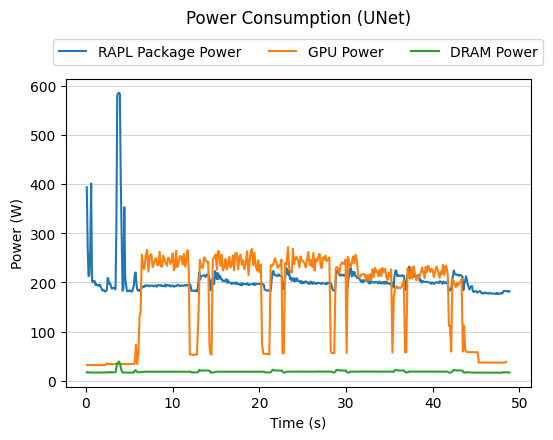

In [7]:
plot_power_CPU_GPU_DRAM(UNet_cpu, UNet_gpu, "UNet",6,4)

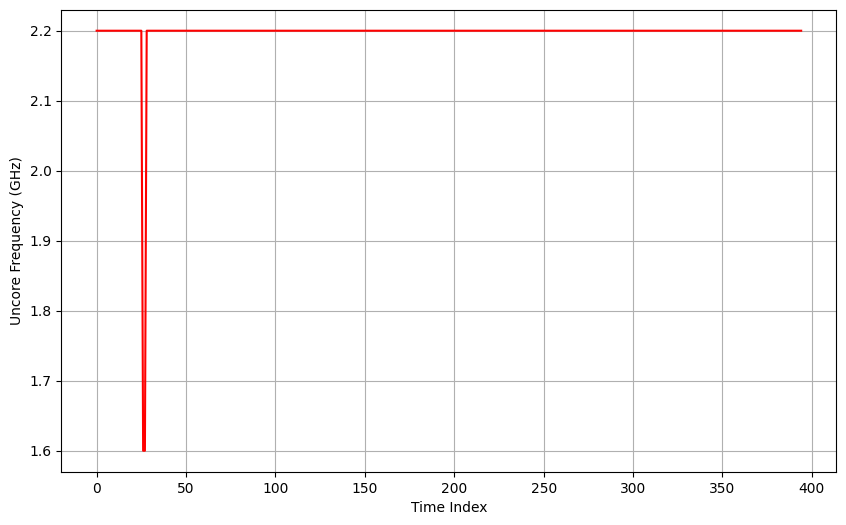

In [8]:
# Assuming the file is available with the specified path
csv_file_path = '/home/cc/power/GPGPU/data/ecp_power_res/no_power_shift/uncore_freq/UNet_uncore_freq.csv'

# Load the CSV file into a DataFrame
df_uncore = pd.read_csv(csv_file_path)

# Plotting the uncore frequency
plt.figure(figsize=(10, 6))
plt.plot(df_uncore.index, df_uncore['Core 0 Uncore Frequency (GHz)'],color="red")
# plt.title('Uncore Frequency Over Time')
plt.xlabel('Time Index')
plt.ylabel('Uncore Frequency (GHz)')
plt.grid(True)
plt.show()

In [5]:
core freq
uncore freq -- ok
clock_freq
mem_freq

SyntaxError: invalid syntax (3093356277.py, line 1)